## 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항	|상세기준| 성취여부|
|:--|:--|:--:|
|1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.|	텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.|O|
|2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.|	학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.|O|
|3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.|	샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.|O|

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 데이터세트 

구성
- target character 정의
- 데이터세트 클래스 작성 : lmdb 데이터 호출 및 resize, getitem 정의
- label converter 정의

#### target 정의

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


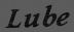

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


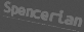

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


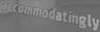

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


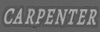

In [3]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [67]:
with env.begin(write=False) as txn:
    label_key = 'label-%09d'.encode() % 1
    label = txn.get(label_key).decode('utf-8')
print(label_key)
print(label)

b'label-000000001'
Lube


#### 데이터세트 클래스 정의

In [4]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs


#### label converter 정의

In [19]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
#          print(self.label_map)
#          print(self.character)
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
#             print(encode, self.character[encode])
            decoded_label += self.character[encode]
         return decoded_label

In [21]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
print()
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]

Decoded_text:  HEL-LO


#### ctc loss를 위한 함수 정의

In [155]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 모델 학습

구성
- CRNN 정의
- Training
- loss 확인
- Inference test

#### CRNN 정의

In [23]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [24]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, 
                              label_converter,
                              batch_size=BATCH_SIZE,
                              character=TARGET_CHARACTERS,
                              is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH,
                            label_converter,
                            batch_size=BATCH_SIZE,
                            character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


#### Training

In [27]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
# [[YOUR CODE]]
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
hist = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 91s 160ms/step - loss: 24.3534 - val_loss: 23.7666

Epoch 00001: val_loss improved from inf to 23.76662, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 90s 158ms/step - loss: 12.2941 - val_loss: 8.4012

Epoch 00002: val_loss improved from 23.76662 to 8.40120, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 85s 151ms/step - loss: 6.6184 - val_loss: 6.0529

Epoch 00003: val_loss improved from 8.40120 to 6.05293, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 83s 147ms/step - loss: 4.9206 - val_loss: 5.2414

Epoch 00004: val_loss improved from 6.05293 to 5.24145, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 83s 147ms/step - loss: 3.9485 - val_loss: 4.7590

Epoch 00005: val_loss impro

#### loss 확인

In [30]:
import matplotlib.pyplot as plt

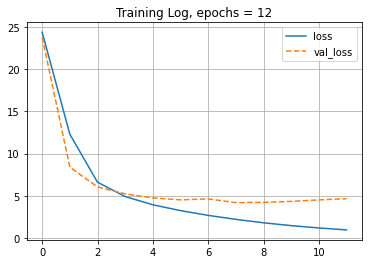

In [37]:
plt.title('Training Log, epochs = 12')
plt.plot(range(12), hist.history['loss'], label = 'loss')
plt.plot(range(12), hist.history['val_loss'], '--',label = 'val_loss')
plt.legend()
plt.grid()
plt.show()

#### Inference test

In [39]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH,
                             label_converter,
                             batch_size=BATCH_SIZE,
                             character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [41]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

Answer: 	 SLINKING
Prediction: 	 SLINKING


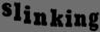

-----------------------------------
Answer: 	 ALEPPO
Prediction: 	 ALEPPO


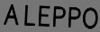

-----------------------------------
Answer: 	 RWANDA
Prediction: 	 FWANDA


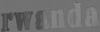

-----------------------------------
Answer: 	 NATHANS
Prediction: 	 NATHANS


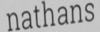

-----------------------------------
Answer: 	 HALLOO
Prediction: 	 HALLE


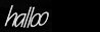

-----------------------------------
Answer: 	 HURLS
Prediction: 	 HURLS


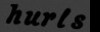

-----------------------------------
Answer: 	 DOWNSIZE
Prediction: 	 DOWNSIZE


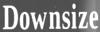

-----------------------------------
Answer: 	 ROBOTIC
Prediction: 	 ROBOTIC


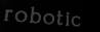

-----------------------------------
Answer: 	 SLOPPY
Prediction: 	 SLOPPY


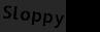

-----------------------------------
Answer: 	 HERMITE
Prediction: 	 SHERMITE


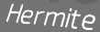

-----------------------------------


In [78]:
# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','').replace('9','')
        print("Answer: \t",  label_converter.decode(dataset[i][0]['label'][0]).replace('-',''))
        print("Prediction: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))
        print('-----------------------------------')

check_inference(model_pred, test_set, index=10)

### END2END 함수 구성

**구성**
1. 글자 영역 인식 모델 불러오기
2. 글자 영역 추출
3. 글자 인식
4. Edit distance(ED) 계산

**return** 
예상 문자와 ED 출력

In [79]:
from PIL import Image, ImageDraw
from IPython.display import display
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [118]:
from PIL import Image, ImageDraw
def detect_text(img_path,size = 640):
    img_p = Image.open(img_path)
    img_p = img_p.resize((size, size))
    img_draw = ImageDraw.Draw(img_p)
    result_img = img_p
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (size, size))
    img = img[tf.newaxis, :, :, :]
    det_result = detector.detect(img.numpy())
    ocr_result = det_result[0]

    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_p.crop(word_box))


    return result_img, cropped_imgs

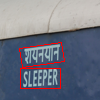

In [110]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [111]:
cropped_img

[<PIL.Image.Image image mode=RGB size=54x35 at 0x7F8E24C44310>,
 <PIL.Image.Image image mode=RGB size=50x30 at 0x7F8E24B39970>]

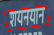

In [112]:
display(cropped_img[0])

In [113]:
display(cropped_img[1])

In [114]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','').replace('9','')
    print("Result: \t", result)
    
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 ROES


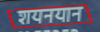

Result: 	 SPPRS


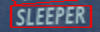

In [115]:
for _img in cropped_img:
    recognize_img(_img)

편집 거리 Edit Distance
- 출처 : [블로그](https://joyjangs.tistory.com/38)
- DP 관련 알고리즘으로 공부할 필요 있음

In [124]:
def edit_dist(str1, str2):
    dp = [[0] * (len(str2)+1) for _ in range(len(str1) + 1)]
    for i in range(1, len(str1)+1):
        dp[i][0] = i
    for j in range(1, len(str2)+1):
        dp[0][j] = j

    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            if str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]

            else:
                dp[i][j] = min(dp[i-1][j-1], dp[i-1][j], dp[i][j-1]) + 1

    return dp[-1][-1]


print(edit_dist('PYTHON', 'PHOTO'))     # 4

4


In [130]:
def recognition_and_getting_point(pil_img, answer, input_img_size=(100,32)):
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','').replace('9','')
    print("Result: \t", result)
    point = edit_dist(answer, result)
    print("Edit Distance: \t", point)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

In [153]:
def end2end(img_path, answers = None ,size = 640):
    img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH, size = size)
    print("Original: \t")
    display(img_pil)
    try:
        for _img, answer in zip(cropped_img,answers):
            recognition_and_getting_point(_img, answer = answer)
    except:
        for _img in cropped_img:
            recognize_img(_img)        

Original: 	


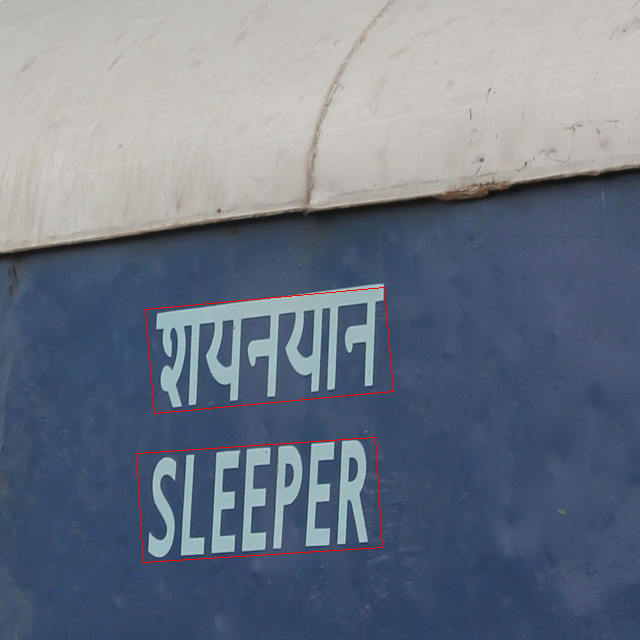

Result: 	 STRUPRUIE


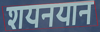

Result: 	 SLEEPERE


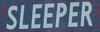

In [154]:
end2end(SAMPLE_IMG_PATH)

### (Additional) 이미지 크기와 글씨 인식률 상관관계 실험

Original: 	


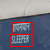

Result: 	 EYS
Edit Distance: 	 6


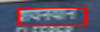

Result: 	 ESNS
Edit Distance: 	 6


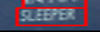

In [133]:
end2end(SAMPLE_IMG_PATH,['FOREIGN','SLEEPER'], size = 50)

Original: 	


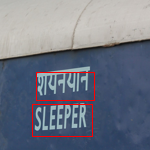

Result: 	 STAPIZS
Edit Distance: 	 6


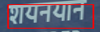

Result: 	 SIEPERS
Edit Distance: 	 3


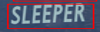

In [134]:
end2end(SAMPLE_IMG_PATH,['FOREIGN','SLEEPER'], size = 150)

Original: 	


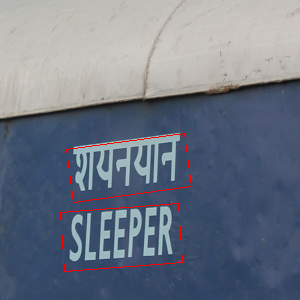

Result: 	 SRAEUIZE
Edit Distance: 	 6


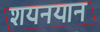

Result: 	 ESLEEPER
Edit Distance: 	 1


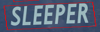

In [135]:
end2end(SAMPLE_IMG_PATH,['FOREIGN','SLEEPER'], size = 300)

Original: 	


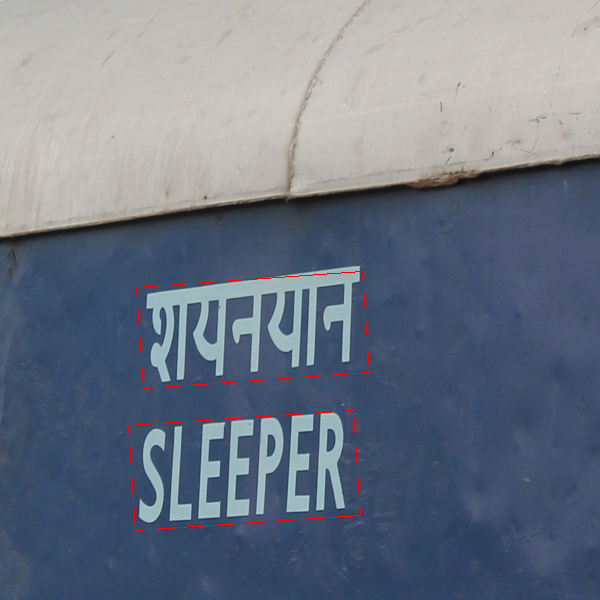

Result: 	 SRUFRUIE
Edit Distance: 	 7


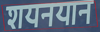

Result: 	 SLEEPERE
Edit Distance: 	 1


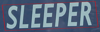

In [136]:
end2end(SAMPLE_IMG_PATH,['FOREIGN','SLEEPER'], size = 600)

Original: 	


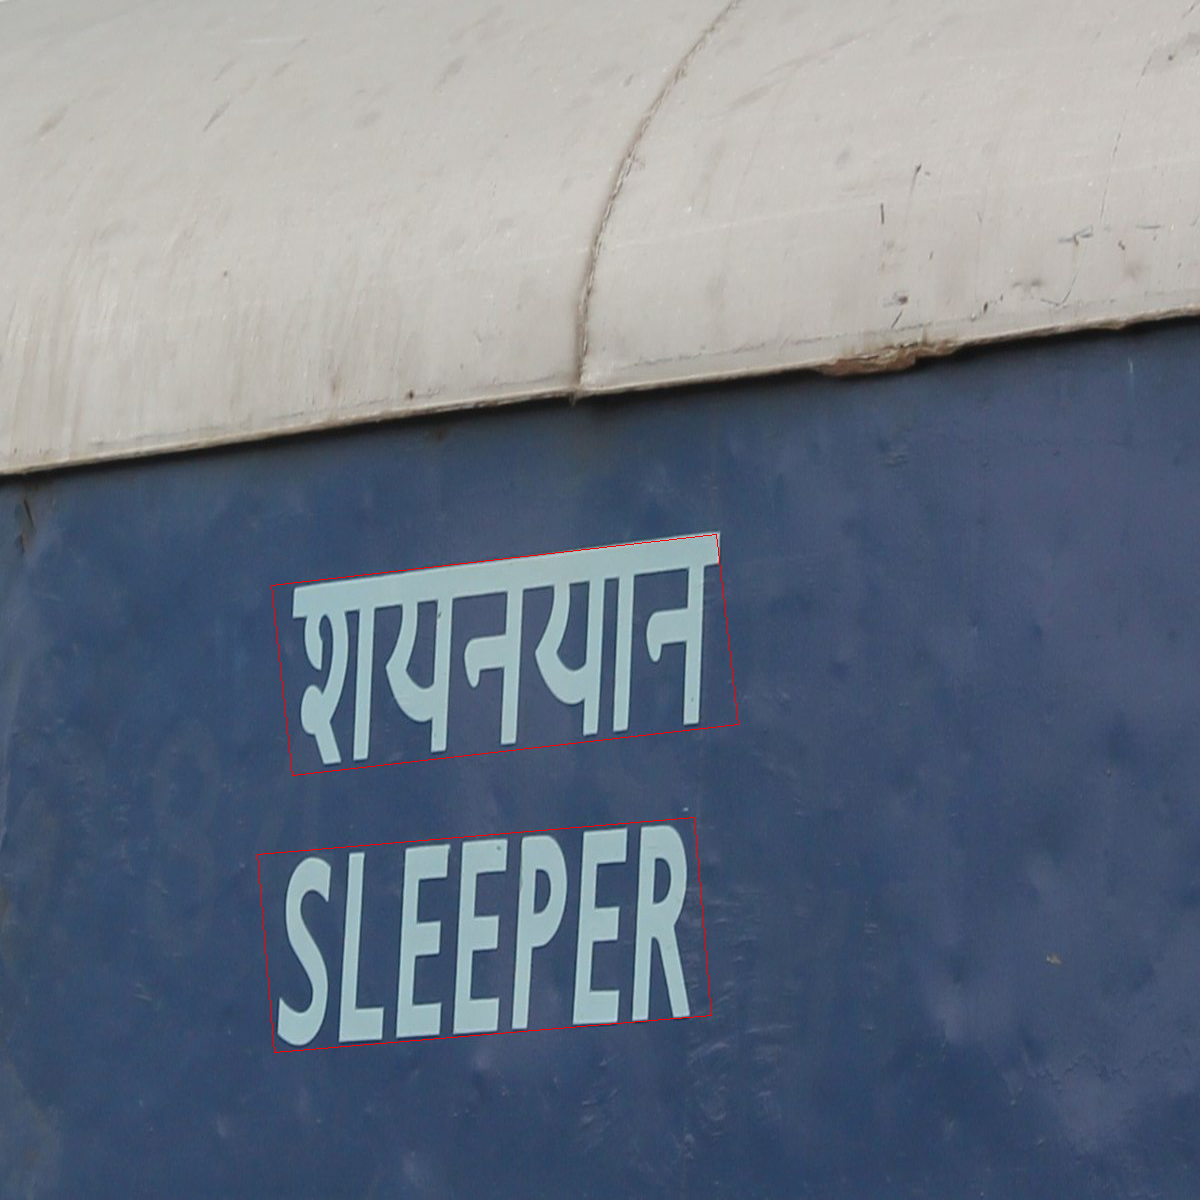

Result: 	 SRUPUIT
Edit Distance: 	 7


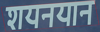

Result: 	 SLEEPER
Edit Distance: 	 0


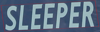

In [137]:
end2end(SAMPLE_IMG_PATH,['FOREIGN','SLEEPER'], size = 1200)

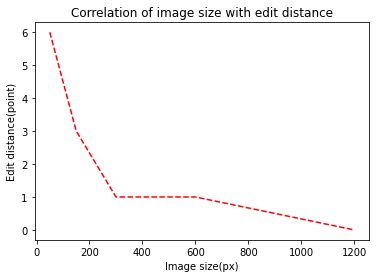

In [148]:
s = [50, 150, 300, 600, 1200] # img_size
p = [6, 3, 1, 1, 0] # ed
plt.title('Correlation of image size with edit distance')
plt.xlabel('Image size(px)')
plt.ylabel('Edit distance(point)')
plt.plot(s, p, 'r--')
plt.show()